# 2A.ML101.2: Basic principles of machine learning with scikit-learn

Classification and regression.

*Source:* [Course on machine learning with scikit-learn](https://github.com/GaelVaroquaux/sklearn_ensae_course) by Gaël Varoquaux

### Introducing the scikit-learn estimator object

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

Every algorithm is exposed in scikit-learn via an ''Estimator'' object. For instance a linear regression is:

In [2]:
from sklearn.linear_model import LinearRegression

**Estimator parameters**: All the parameters of an estimator can be set when it is instantiated:

In [3]:
model = LinearRegression(normalize=True)
print(model.normalize)

True


In [4]:
print(model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


### Fitting on data

In [5]:
x = np.array([0, 1, 2])
y = np.array([0, 1, 2])

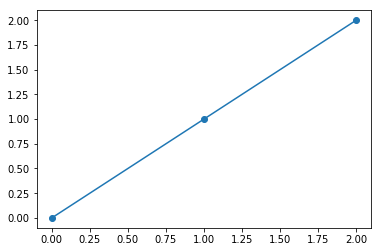

In [6]:
_ = plt.plot(x, y, marker='o')

In [7]:
X = x[:, np.newaxis] # The input data for sklearn is 2D: (samples == 3 x features == 1)
X

array([[0],
       [1],
       [2]])

In [8]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

**Estimated parameters**: When data is fitted with an estimator, parameters are estimated from the data at hand. All the estimated parameters are attributes of the estimator object ending by an underscore:

In [9]:
model.coef_

array([1.])

### Supervised Learning: Classification and regression

In **Supervised Learning**, we have a dataset consisting of both features and labels.
The task is to construct an estimator which is able to predict the label of an object
given the set of features. A relatively simple example is predicting the species of 
iris given a set of measurements of its flower. This is a relatively simple task. 
Some more complicated examples are:

- given a multicolor image of an object through a telescope, determine
  whether that object is a star, a quasar, or a galaxy.
- given a photograph of a person, identify the person in the photo.
- given a list of movies a person has watched and their personal rating
  of the movie, recommend a list of movies they would like
  (So-called *recommender systems*: a famous example is the [Netflix Prize](http://en.wikipedia.org/wiki/Netflix_prize)).

What these tasks have in common is that there is one or more unknown
quantities associated with the object which needs to be determined from other
observed quantities.

Supervised learning is further broken down into two categories, **classification** and **regression**.
In classification, the label is discrete, while in regression, the label is continuous. For example,
in astronomy, the task of determining whether an object is a star, a galaxy, or a quasar is a
classification problem: the label is from three distinct categories. On the other hand, we might
wish to estimate the age of an object based on such observations: this would be a regression problem,
because the label (age) is a continuous quantity.

**Classification**: K nearest neighbors (kNN) is one of the simplest learning strategies: given a new, unknown observation, look up in your reference database which ones have the closest features and assign the predominant class.

Let's try it out on our iris classification problem:

In [10]:
from sklearn import neighbors, datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
# What kind of iris has 3cm x 5cm sepal and 4cm x 2cm petal?
print(iris.target_names[knn.predict([[3, 5, 4, 2]])])

['virginica']


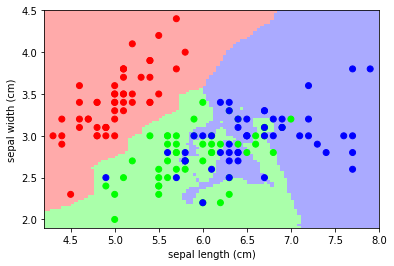

In [11]:
# A plot of the sepal space and the prediction of the KNN
from helpers import plot_iris_knn
plot_iris_knn()

**Regression**: The simplest possible regression setting is the linear regression one:

Model coefficient: 3.93491, and intercept: 1.46229


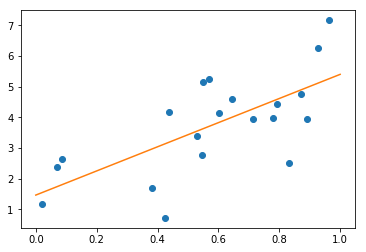

In [12]:
# Create some simple data
import numpy as np
np.random.seed(0)
X = np.random.random(size=(20, 1))
y = 3 * X[:, 0] + 2 + np.random.normal(size=20)

# Fit a linear regression to it
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
print("Model coefficient: %.5f, and intercept: %.5f"
      % (model.coef_, model.intercept_))

# Plot the data and the model prediction
X_test = np.linspace(0, 1, 100)[:, np.newaxis]
y_test = model.predict(X_test)
import pylab as pl
plt.plot(X[:, 0], y, 'o')
plt.plot(X_test[:, 0], y_test);

### A recap on Scikit-learn's estimator interface

Scikit-learn strives to have a uniform interface across all methods,
and we’ll see examples of these below. Given a scikit-learn *estimator*
object named `model`, the following methods are available:

- Available in **all Estimators**
  + `model.fit()` : fit training data. For supervised learning applications,
    this accepts two arguments: the data `X` and the labels `y` (e.g. `model.fit(X, y)`).
    For unsupervised learning applications, this accepts only a single argument,
    the data `X` (e.g. `model.fit(X)`).
- Available in **supervised estimators**
  + `model.predict()` : given a trained model, predict the label of a new set of data.
    This method accepts one argument, the new data `X_new` (e.g. `model.predict(X_new)`),
    and returns the learned label for each object in the array.
  + `model.predict_proba()` : For classification problems, some estimators also provide
    this method, which returns the probability that a new observation has each categorical label.
    In this case, the label with the highest probability is returned by `model.predict()`.
  + `model.score()` : for classification or regression problems, most (all?) estimators implement
    a score method.  Scores are between 0 and 1, with a larger score indicating a better fit.
- Available in **unsupervised estimators**
  + `model.transform()` : given an unsupervised model, transform new data into the new basis.
    This also accepts one argument `X_new`, and returns the new representation of the data based
    on the unsupervised model.
  + `model.fit_transform()` : some estimators implement this method,
    which more efficiently performs a fit and a transform on the same input data.

### Regularization: what it is and why it is necessary

**Train errors** Suppose you are using a 1-nearest neighbor estimator. How many errors do you expect on your train set?

- Train set error is not a good measurement of prediction performance. You need to leave out a test set.
- In general, we should accept errors on the train set.

**An example of regularization** The core idea behind regularization is that we are going to prefer models that are simpler, for a certain definition of ''simpler'', even if they lead to more errors on the train set.

As an example, let's generate with a 9th order polynomial.

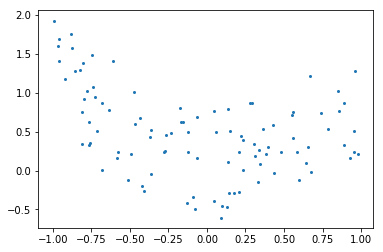

In [13]:
rng = np.random.RandomState(0)
x = 2 * rng.rand(100) - 1

f = lambda t: 1.2 * t ** 2 + .1 * t ** 3 - .4 * t ** 5 - .5 * t ** 9
y = f(x) + .4 * rng.normal(size=100)

plt.figure()
plt.scatter(x, y, s=4);

And now, let's fit a 4th order and a 9th order polynomial to the data. For this we need to engineer features: the n_th powers of x:

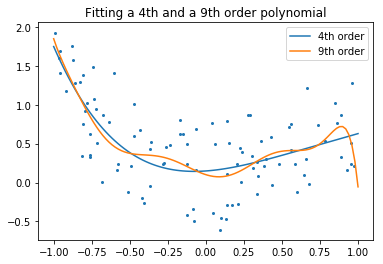

In [14]:
x_test = np.linspace(-1, 1, 100)

plt.figure()
plt.scatter(x, y, s=4)

X = np.array([x**i for i in range(5)]).T
X_test = np.array([x_test**i for i in range(5)]).T
order4 = LinearRegression()
order4.fit(X, y)
plt.plot(x_test, order4.predict(X_test), label='4th order')

X = np.array([x**i for i in range(10)]).T
X_test = np.array([x_test**i for i in range(10)]).T
order9 = LinearRegression()
order9.fit(X, y)
plt.plot(x_test, order9.predict(X_test), label='9th order')

plt.legend(loc='best')
plt.axis('tight')
plt.title('Fitting a 4th and a 9th order polynomial');

With your naked eyes, which model do you prefer, the 4th order one, or the 9th order one?

Let's look at the ground truth:

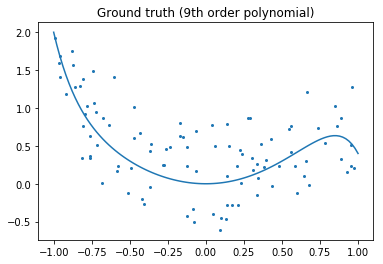

In [15]:
plt.figure()
plt.scatter(x, y, s=4)
plt.plot(x_test, f(x_test), label="truth")
plt.axis('tight')
plt.title('Ground truth (9th order polynomial)');

Regularization is ubiquitous in machine learning. Most scikit-learn estimators have a parameter to tune the amount of regularization. For instance, with k-NN, it is 'k', the number of nearest neighbors used to make the decision. k=1 amounts to no regularization: 0 error on the training set, whereas large k will push toward smoother decision boundaries in the feature space.

### Exercise: Interactive Demo on linearly separable data

Run the **svm_gui.py** file in the repository: https://github.com/GaelVaroquaux/sklearn_ensae_course



______


